# Entraînement des modèles

Afin de coder notre application, nous devons entraîner deux modèles de machine learning. Le premier modèle sera un modèle de prédiction de l'affluence, et le second un modèle de prédiction du gaspillage. Il faudra pour chacun de ces deux modèles effectuer une sélection des variables pertinentes.
Attention à ne pas fournir les targets lors de l'entraînement des modèles, il faut partir du principe que l'on ne connaît ni l'affluence, ni le gaspillage à l'avance.
Pour évaluer la qualité de nos modèles, il faudra trouver des KPIs pertinents et les calculer sur un jeu de données de test.

## Lecture du dataset

In [1]:
# Import des librairies
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
#import umap.umap_ as umap
#from sklearn.compose import ColumnTransformer
#from sklearn.decomposition import PCA
#from sklearn.metrics import r2_score
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from tqdm import tqdm
from transformers import CamembertModel, CamembertTokenizer

c:\Users\achir\Downloads\KESKIA_Predictive_Cantine-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
# Import du dataset nettoyé et préparé

data = pd.read_csv('data/Dataset_Grigny_E_AimeCesaire.csv', sep=';')
dataset_cleaned = data.dropna(subset=['menu'])
dataset_cleaned.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/Dataset_Grigny_E_AimeCesaire.csv'

In [15]:
# Lister les colonnes du dataset

df.columns

Index(['date', 'prevision', 'reel', 'effectif', 'taux_grevistes', 'nos', 'ind',
       'greves_manquantes', 'menu', 'ferie', 'veille_ferie', 'retour_ferie',
       'vacances', 'retour_vacances', 'veille_vacances', 'inc_grippe',
       'inc_gastro', 'inc_varicelle', 'fete_musulmane', 'ramadan',
       'fete_chretienne', 'fete_juive', 'jour', 'semaine', 'mois',
       'annee_scolaire', 'repas_noel', 'gaspillage_volume',
       'gaspillage_pourcentage', 'porc', 'viande', 'poisson',
       '4_premiers_jours', '4_derniers_jours', 'Entrée', 'Plat',
       'Accompagnement', 'Fromage', 'Dessert', 'Entrée Food Type',
       'Plat Food Type', 'Accompagnement Food Type', 'Fromage Food Type',
       'Dessert Food Type', 'Entrée_Bio', 'Plat_Bio', 'Accompagnement_Bio',
       'Fromage_Bio', 'Dessert_Bio'],
      dtype='object')

# Calcul des embeddings des menus

Afin de pouvoir traiter la variable menus, il faut la transformer dans un format acceptable pour un modèle de machine learning. Nous allons pour cela calculer les embeddings de ces menus à l'aide d'un algorithme de NLP (BERT).

In [16]:
# N'effectuer cette étape que si les fichiers contenant les embeddings n'existent pas encore
if not os.path.exists('data/embeddings_menu.csv'):
    tokenizer = CamembertTokenizer.from_pretrained("dangvantuan/sentence-camembert-large")
    model = CamembertModel.from_pretrained("dangvantuan/sentence-camembert-large")

    # Fonction pour obtenir les embeddings de phrase à partir du modèle CamemBERT
    def get_sentence_embeddings(texts):
        embeddings = []  # Initialize an empty list to store embeddings for each text

        # Loop over each text in the 'texts' input
        for text_list in tqdm(texts):
            # Concatenate list elements into a single string
            text = ' '.join(text_list)

            # Tokenize the text using the provided tokenizer
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

            # Pass the tokenized input through the model to get the outputs
            outputs = model(**inputs)

            # Extract the mean of the last hidden state along axis 1 (time dimension)
            # Squeeze removes dimensions of size 1 for compatibility with numpy
            # Detach detaches the output from the computation graph
            # Convert the tensor to a numpy array and append to the embeddings list
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())

        # Stack the list of embeddings into a single 2D array
        embeddings = np.stack(embeddings, axis=0)

        # Return the concatenated embeddings array
        return embeddings

    embeddings_menu = get_sentence_embeddings(df['menu'].values)
    # convert embeddings to dataframe and save to csv
    embeddings_menu = pd.DataFrame(embeddings_menu)
    embeddings_menu.to_csv('data/embeddings_menu.csv', index=False)
else:
    embeddings_menu = pd.read_csv('data/embeddings_menu.csv')



## Visualisation des embeddings
Afin de visualiser nos embeddings, et pour améliorer le temps d'entrainement de notre algorithme, nous devons procéder à une réduction de dimensions.
Le but de cette opération est de réduire le nombre de dimensions de nos embeddings tout en conservant le maximum d'informations. Pour cela, nous allons utiliser l'algorithme PCA (Principal Component Analysis).
Nous allons d'abord déterminer le nombre de dimensions à conserver pour notre PCA, puis nous allons appliquer cet algorithme à nos embeddings.
Nous effectuerons aussi une visualisation de nos embeddings réduits en 3 dimensions.

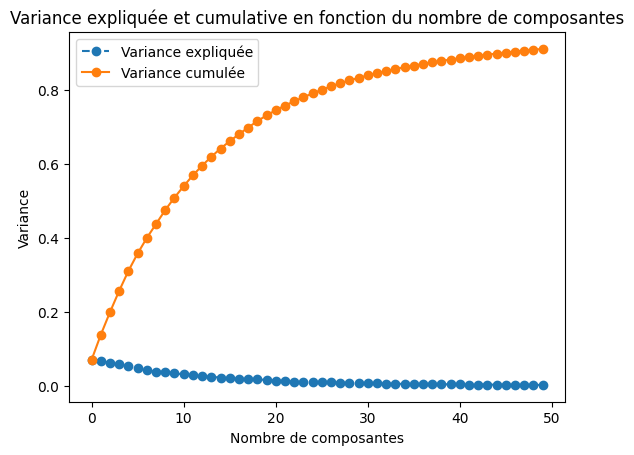

In [17]:
X = embeddings_menu.values

# Normaliser les données (important pour l'ACP)
# Vous pouvez utiliser StandardScaler de scikit-learn pour cela
# Assurez-vous d'avoir installé la bibliothèque en utilisant pip install scikit-learn

X_scaled = StandardScaler().fit_transform(X)

# Appliquer l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculer la variance expliquée pour chaque composante
explained_variance = pca.explained_variance_ratio_

# Calculer la variance cumulée
cumulative_variance = np.cumsum(explained_variance)

# Tracer la variance expliquée et la variance cumulée en fonction du nombre de composantes
plt.plot(range(0, 50), explained_variance[:50], marker='o', linestyle='--', label='Variance expliquée')
plt.plot(range(0, 50), cumulative_variance[:50], marker='o', label='Variance cumulée')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance')
plt.title('Variance expliquée et cumulative en fonction du nombre de composantes')
plt.legend()
plt.show()

In [18]:
# Utiliser 20 composantes principales pour l'ACP semble être un bon compromis
# Nous allons donc réappliquer l'ACP avec 20 composantes principales
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Créer un dataframe à partir des composantes principales

pca_df = pd.DataFrame(X_pca, columns=['pca_{}'.format(i) for i in range(1, n_components + 1)])

# Ajouter les colonnes du dataframe pca_df au dataframe df

df = pd.concat([df, pca_df], axis=1)

### Visualisation 3D en utilisant UMAP

In [19]:
# Create a UMAP model with 3 components
umap_model = umap.UMAP(n_components=3)

# Fit the UMAP model to the embeddings
X_umap = umap_model.fit_transform(embeddings_menu.values)

# Create a dataframe with the UMAP embeddings
umap_df = pd.DataFrame(X_umap, columns=['UMAP_1', 'UMAP_2', 'UMAP_3'])

# Create a 3D scatter plot with Plotly
fig = px.scatter_3d(umap_df, x='UMAP_1', y='UMAP_2', z='UMAP_3', hover_data=[df['menu']])
fig.show()


## Sélection des variables, preprocessing et entraînement du modèle

In [20]:
# Définir les colonnes à utiliser pour notre X ( les features ) et nos Y ( les targets )

# Attention, votre selection peut être différente de la mienne, en fonction de vos choix de features,
# vous pouvez/devez vous réferer à votre notebook 2_Exploration_des_Données.ipynb

numerical_features = ['effectif', 'taux_grevistes', 'inc_grippe', 'inc_gastro', 'inc_varicelle', 'prevision']

numerical_features += ['pca_{}'.format(i) for i in range(1, n_components + 1)]

categorical_features = ['veille_ferie', 'retour_ferie', 'vacances', 'retour_vacances', 'veille_vacances',
                        'fete_musulmane', 'ramadan', 'fete_chretienne', 'fete_juive', 'repas_noel', 'porc', 'viande',
                        'poisson', '4_premiers_jours', '4_derniers_jours', 'Entrée_Bio', 'Plat_Bio', 'Accompagnement_Bio', 'Fromage_Bio', 'Dessert_Bio']


list_targets = ['reel', 'gaspillage_pourcentage']



# Création de notre X et de nos Y

X = df[numerical_features + categorical_features]

#X = pd.get_dummies(X, columns=categorical_features)

Y_gaspillage_pourcentage = df['gaspillage_pourcentage']

Y_affluence_reelle = df['reel']

### Split en Dataset d'entraînement et de test

In [21]:
# Création de nos datasets de train et de test

X_train, X_test, y_train_gaspillage_pourcentage, y_test_gaspillage_pourcentage, y_train_affluence_reelle, y_test_affluence_reelle = train_test_split(
    X, Y_gaspillage_pourcentage, Y_affluence_reelle, test_size=0.2, random_state=42)

## Preprocessing des données

Afin de préparer nos données pour l'entraînement des modèles, nous allons effectuer les opérations suivantes :

- Pour les variables numériques : 
  - Scaling des données


In [22]:
# Créer les transformers pour le prétraitement des données

numerical_preprocessing = Pipeline(steps=[
    ('scaler', StandardScaler())])
    
categories_preprocessing = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Créer le ColumnTransformer pour appliquer les transformers sur les colonnes concernées

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessing, numerical_features),
        ('cat', categories_preprocessing, categorical_features)],
        remainder='passthrough')




In [23]:
# Créer une liste de modèles de regression à tester
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
            ElasticNet(random_state=42),
            SVR(kernel='linear'),
            SVR(kernel='rbf'),
            XGBRegressor(random_state=42, n_estimators=100, max_depth=10)]


# Créer une liste de noms de modèles de regression à tester
model_names = ['RandomForestRegressor',
               'ElasticNet',
               'SVR_linear',
               'SVR_rbf',
               'XGBRegressor']

# Créer une liste pour stocker les scores de chaque modèle

scores_gaspillage_pourcentage = []
scores_affluence_reelle = []
mean_absolute_error_gaspillage_pourcentage = []
mean_absolute_error_affluence_reelle = []
mean_squared_error_gaspillage_pourcentage = []
mean_squared_error_affluence_reelle = []

# Pour chaque modèle, appliquer le pipeline de preprocessing, entraîner le modèle, prédire sur l'ensemble de test et calculer le score

for model in tqdm(models):
    pipeline_affluence_reelle = Pipeline(steps=[('preprocessor', preprocessor),
                                                    ('model', model)])
    pipeline_affluence_reelle.fit(X_train, y_train_affluence_reelle)
    y_pred_affluence_reelle = pipeline_affluence_reelle.predict(X_test)
    score_affluence_reelle = r2_score(y_test_affluence_reelle, y_pred_affluence_reelle)
    mae_affluence_reelle = mean_absolute_error(y_test_affluence_reelle, y_pred_affluence_reelle)
    mse_affluence_reelle = mean_squared_error(y_test_affluence_reelle, y_pred_affluence_reelle)
    scores_affluence_reelle.append(score_affluence_reelle)
    mean_absolute_error_affluence_reelle.append(mae_affluence_reelle)
    
    pipeline_gaspillage_pourcentage = Pipeline(steps=[('preprocessor', preprocessor),
                                                    ('model', model)])
    pipeline_gaspillage_pourcentage.fit(X_train, y_train_gaspillage_pourcentage)
    y_pred_gaspillage_pourcentage = pipeline_gaspillage_pourcentage.predict(X_test)
    score_gaspillage_pourcentage = r2_score(y_test_gaspillage_pourcentage, y_pred_gaspillage_pourcentage)
    mae_gaspillage_pourcentage = mean_absolute_error(y_test_gaspillage_pourcentage, y_pred_gaspillage_pourcentage)
    mse_gaspillage_pourcentage = mean_squared_error(y_test_gaspillage_pourcentage, y_pred_gaspillage_pourcentage)
    scores_gaspillage_pourcentage.append(score_gaspillage_pourcentage)
    mean_absolute_error_gaspillage_pourcentage.append(mae_gaspillage_pourcentage)
    



# Créer un dataframe avec les scores de chaque modèle arrondis à 2 chiffres après la virgule

scores_df = pd.DataFrame({'Modèle': model_names,
                          'R2 Score affluence': scores_affluence_reelle,
                          'MAE affluence': mean_absolute_error_affluence_reelle,
                            'R2 Score gaspillage': scores_gaspillage_pourcentage,
                            'MAE gaspillage': mean_absolute_error_gaspillage_pourcentage})

scores_df = scores_df.round(2)

# Afficher le dataframe

scores_df

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


,Modèle,R2 Score affluence,MAE affluence,R2 Score gaspillage,MAE gaspillage
0,RandomForestRegressor,0.68,387.18,0.15,2.37
1,ElasticNet,0.63,507.14,-0.02,2.94
2,SVR_linear,0.66,420.22,0.18,2.23
3,SVR_rbf,0.03,896.57,0.05,2.41
4,XGBRegressor,0.59,409.06,-0.85,2.99


In [24]:
from tpot import TPOTRegressor
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


tpot = TPOTRegressor(generations=10, population_size=100, verbosity=2, random_state=42, n_jobs=-1, scoring='r2', config_dict='TPOT sparse' )
tpot.fit(X_train_scaled, y_train_affluence_reelle)


Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6024730736520638

Generation 2 - Current best internal CV score: 0.6024730736520638

Generation 3 - Current best internal CV score: 0.6024730736520638

Generation 4 - Current best internal CV score: 0.6024730736520638

Generation 5 - Current best internal CV score: 0.6024730736520638

Generation 6 - Current best internal CV score: 0.6024730736520638

Generation 7 - Current best internal CV score: 0.6077315666584845

Generation 8 - Current best internal CV score: 0.6103776013482308

Generation 9 - Current best internal CV score: 0.6103776013482308

Generation 10 - Current best internal CV score: 0.6200850031727193

Best pipeline: RandomForestRegressor(RidgeCV(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=16, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8500000000000001, verbosity=0)), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=4, n_estimato

TPOTRegressor(config_dict='TPOT sparse', generations=10, n_jobs=-1,
              random_state=42, scoring='r2', verbosity=2)

In [26]:
tpot.score(X_test_scaled, y_test_affluence_reelle)



0.6487180014038989

In [31]:
data_dashboard = df
data_dashboard['affluence_reelle'] = Y_affluence_reelle
data_dashboard['gaspillage_pourcentage'] = Y_gaspillage_pourcentage
data_dashboard['affluence_reelle_predite'] = tpot.predict(preprocessor.transform(X))
data_dashboard.columns

Index(['date', 'prevision', 'reel', 'effectif', 'taux_grevistes', 'nos', 'ind',
       'greves_manquantes', 'menu', 'ferie', 'veille_ferie', 'retour_ferie',
       'vacances', 'retour_vacances', 'veille_vacances', 'inc_grippe',
       'inc_gastro', 'inc_varicelle', 'fete_musulmane', 'ramadan',
       'fete_chretienne', 'fete_juive', 'jour', 'semaine', 'mois',
       'annee_scolaire', 'repas_noel', 'gaspillage_volume',
       'gaspillage_pourcentage', 'porc', 'viande', 'poisson',
       '4_premiers_jours', '4_derniers_jours', 'Entrée', 'Plat',
       'Accompagnement', 'Fromage', 'Dessert', 'Entrée Food Type',
       'Plat Food Type', 'Accompagnement Food Type', 'Fromage Food Type',
       'Dessert Food Type', 'Entrée_Bio', 'Plat_Bio', 'Accompagnement_Bio',
       'Fromage_Bio', 'Dessert_Bio', 'pca_1', 'pca_2', 'pca_3', 'pca_4',
       'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11',
       'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18',
       'pca_

In [35]:
data_dashboard['gaspillage_predit'] = data_dashboard['affluence_reelle_predite'] - data_dashboard['affluence_reelle']
data_dashboard['gaspillage_predit_pourcentage'] = data_dashboard['gaspillage_predit'] / data_dashboard['affluence_reelle_predite'] * 100

In [36]:
data_dashboard.drop(columns=['pca_1', 'pca_2', 'pca_3', 'pca_4',
       'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11',
       'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18',
       'pca_19', 'pca_20'], inplace=True)
data_dashboard.columns

KeyError: "['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20'] not found in axis"

In [37]:
data_dashboard.to_csv('data/data_dashboard.csv', index=False)